In [1]:
from dn import DeltaNeutral
from api import FtxClient
from client import FtxWebsocketClient
from utils.log import setup_custom_logger
from collections import defaultdict, deque
import logging
from utils import config
from threading import Thread, Lock
import pandas as pd
import dateutil.parser as dp
import time
import datetime
import os
import math
import sys
import datetime
import numpy as np
from dn import DeltaNeutral
from arch import arch_model
from random import gauss
import matplotlib.pyplot as plt
from arch.__future__ import reindexing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils.file_to_json import file_setting, file_coin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


In [184]:
n = 10000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.12)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)


Text(0.5, 1.0, 'Simulated GARCH(2,2) Data')

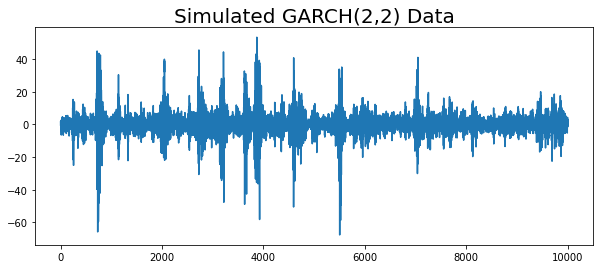

In [185]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('Simulated GARCH(2,2) Data', fontsize=20)

PACF

Text(0.5, 1.0, 'Data and Volatility')

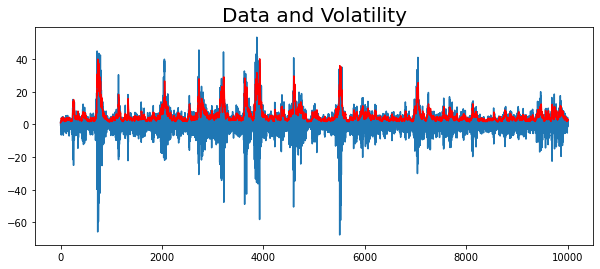

In [186]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.plot(vols, color='red')
plt.title('Data and Volatility', fontsize=20)

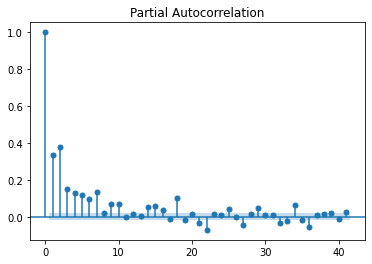

In [187]:
plot_pacf(np.array(series)**2)
plt.show()

In [188]:
train, test = series[:-test_size], series[-test_size:]
model = arch_model(train, p=2, q=2)
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 610270416536.0956
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3937658637.7110357
Iteration:      3,   Func. Count:     27,   Neg. LLF: 30666.62706854464
Iteration:      4,   Func. Count:     35,   Neg. LLF: 27070.6833552281
Iteration:      5,   Func. Count:     43,   Neg. LLF: 25989.903902848157
Iteration:      6,   Func. Count:     51,   Neg. LLF: 25640.01351170477
Iteration:      7,   Func. Count:     59,   Neg. LLF: 26046.778225261332
Iteration:      8,   Func. Count:     67,   Neg. LLF: 25548.51235930097
Iteration:      9,   Func. Count:     75,   Neg. LLF: 25876.30011840338
Iteration:     10,   Func. Count:     83,   Neg. LLF: 25525.8220411093
Iteration:     11,   Func. Count:     91,   Neg. LLF: 25523.987889399592
Iteration:     12,   Func. Count:     99,   Neg. LLF: 25694.894210583134
Iteration:     13,   Func. Count:    107,   Neg. LLF: 25520.626746278293
Iteration:     14,   Func. Count:    114,   Neg. LLF: 25520.

In [189]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -25520.6
Distribution:                  Normal   AIC:                           51053.2
Method:            Maximum Likelihood   BIC:                           51095.7
                                        No. Observations:                 8802
Date:                Fri, Apr 30 2021   Df Residuals:                     8801
Time:                        01:37:27   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0221  3.502e-02      0.630      0.529 [-4.658e-02,9.069e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5229  7.105e-02      7.360  1.838e-13   [  0.384,  0.662]
alpha[1]       0.0964  1.275e-02      7.565  3.878e-14 [7.145e-02,  0.121]
alpha[2]       0.1895  1.659e-02     11.424  3.168e-30   [  0.157,  0.222]
beta[1]        0.2826  7.423e-02      3.808  1.404e-04   [  0.137,  0.428]
beta[2]        0.4268  6.388e-02      6.681  2.372e-11   [  0.302,  0.552]
==========================================================================

Covariance estimator: robust
"""

### Prediction

In [190]:
predictions = model_fit.forecast(horizon=test_size)

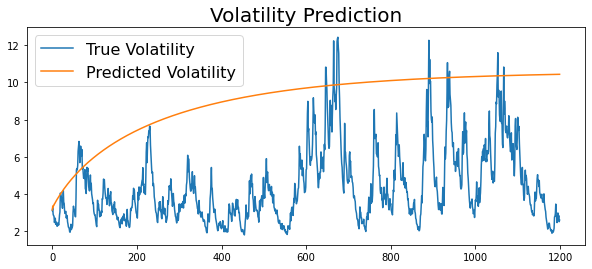

In [191]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))
plt.title('Volatility Prediction', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

In [192]:
rolling_predictions = []
for i in range(test_size):
    train = series[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

KeyboardInterrupt: 

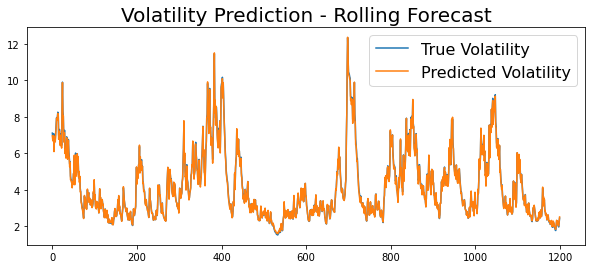

In [11]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

## real time tick data

### Rolling Forecast

In [418]:
returns = df[df['return'] <= 2][df['return'] >= -2]['spread']
# returns = df[df['return'] <= 2][df['return'] >= -2]['return']

rolling_predictions = []
returns = np.array(returns)
test_size = len(returns)

# for i in range(1,int(len(returns)/test_size)):
#     train = returns[:-(len(returns) - test_size*i)]
#     model = arch_model(train, p=2, q=2)
#     model_fit = model.fit(disp='off')
#     pred = model_fit.forecast(horizon=test_size)
#     rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

for i in range(1,test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=10)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

ite-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000887. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/harry/.local/lib/python3.9/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/harry/.local/lib/python3.9/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poor

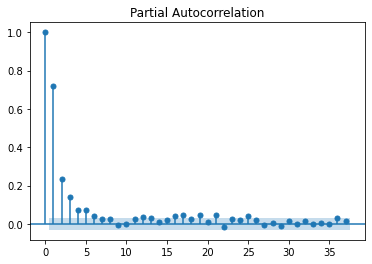

In [85]:
plot_pacf(returns**2)
plt.show()

<ipython-input-419-7617d3bc3944>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true, = plt.plot(df[df['return'] <= 2][df['return'] >= -2]['spread'])


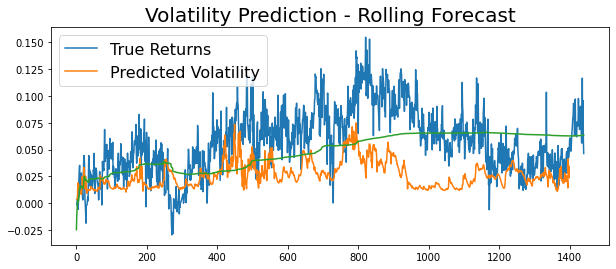

In [419]:
df['ma'] = df['spread'].rolling(30).mean()

plt.figure(figsize=(10,4))
true, = plt.plot(df[df['return'] <= 2][df['return'] >= -2]['spread'])
preds, = plt.plot(rolling_predictions)
plt.plot(df['vwma'])
# plt.plot(df['ma'])

plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

### Plotting High/low spread with GARCH predicted volatility

In [4]:
settings = file_setting
coin = file_coin
dn = DeltaNeutral(coin, settings)
df_og = dn._fetch_data(14400, 0.5)
df = df_og.copy()

645445
Adding 5000 trades with end time 1619467719.404586
Adding 5000 trades with end time 1619463139.858491
Adding 5000 trades with end time 1619457778.386262
Adding 5000 trades with end time 1619454192.294075
Adding 5000 trades with end time 1619451357.815279
Adding 5000 trades with end time 1619446653.764638
Adding 5000 trades with end time 1619442138.721457
Adding 5000 trades with end time 1619437338.6104
Adding 5000 trades with end time 1619431521.518536
Adding 5000 trades with end time 1619428089.258313
Adding 5000 trades with end time 1619422898.482289
Adding 5000 trades with end time 1619419570.954908
Adding 5000 trades with end time 1619417255.97609
Adding 5000 trades with end time 1619413671.340203
Adding 5000 trades with end time 1619409724.797937
Adding 5000 trades with end time 1619407005.408543
Adding 5000 trades with end time 1619405579.452561
Adding 5000 trades with end time 1619404580.16854
Adding 5000 trades with end time 1619403426.801583
Adding 5000 trades with end 

<ipython-input-5-d7f64606a2c8>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  returns = df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_avg']
<ipython-input-5-d7f64606a2c8>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_high'])
<ipython-input-5-d7f64606a2c8>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_low'])
<ipython-input-5-d7f64606a2c8>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_avg'])
<ipython-input-5-d7f64606a2c8>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['ma'])


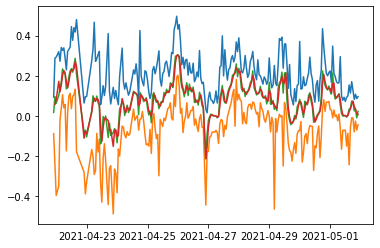

In [5]:
df['volume'] = df['perp_size']+df['spot_size']
df['vwma'] = (df['volume'] * df['spread_avg']).cumsum() / df['volume'].cumsum()
df['return'] = df.spread_avg.pct_change()
df['ma'] = df['spread_avg'].rolling(2).mean()
returns = df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_avg']
plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_high'])
plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_low'])
plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_avg'])
plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['ma'])


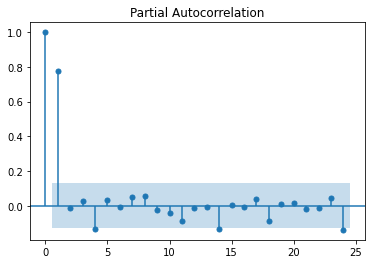

In [6]:
plot_pacf(returns**2)
plt.show()

In [7]:
n = len(returns)
test_size = int(n/180)
train, test = returns[:-test_size], returns[-test_size:]


In [8]:
model = arch_model(train, p=1, q=1)
model_fit = model.fit()
model_fit.summary()
# pred.variance.values

Iteration:      1,   Func. Count:      6,   Neg. LLF: 229.42709066639756
Iteration:      2,   Func. Count:     14,   Neg. LLF: 346.61024973350544
Iteration:      3,   Func. Count:     20,   Neg. LLF: 530133.9504544467
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3149.1111415139717
Iteration:      5,   Func. Count:     32,   Neg. LLF: -260.8327077078684
Iteration:      6,   Func. Count:     37,   Neg. LLF: -261.8384264168598
Iteration:      7,   Func. Count:     42,   Neg. LLF: -240.22698952625157
Iteration:      8,   Func. Count:     48,   Neg. LLF: -263.9691536797825
Iteration:      9,   Func. Count:     53,   Neg. LLF: -155.5489183202903
Iteration:     10,   Func. Count:     59,   Neg. LLF: -262.1582053435228
Iteration:     11,   Func. Count:     65,   Neg. LLF: -264.26384729936314
Iteration:     12,   Func. Count:     71,   Neg. LLF: -264.2958983138253
Iteration:     13,   Func. Count:     77,   Neg. LLF: -264.3071944963523
Iteration:     14,   Func. Count:     82,   Neg. L

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             spread_avg   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                264.307
Distribution:                  Normal   AIC:                          -520.614
Method:            Maximum Likelihood   BIC:                          -506.950
                                        No. Observations:                  225
Date:                Sat, May 01 2021   Df Residuals:                      224
Time:                        19:07:41   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0969  1.300e-02      7.452  9.193e-14 [7.142e-02,  0.122]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.7943e-03  5.495e-04      3.265  1.093e-03 [7.173e-04,2.871e-03]
alpha[1]       0.8934      0.217      4.119  3.804e-05     [  0.468,  1.318]
beta[1]        0.0201  7.073e-02      0.284      0.777     [ -0.119,  0.159]
============================================================================

Covariance estimator: robust
"""

In [37]:
# returns = df[df['return'] <= 2][df['return'] >= -2]['return']

rolling_predictions = []
returns = np.array(returns)
test_size = len(returns)

for i in range(1,test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=2)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

model or by setting rescale=False.

  warnings.warn(
/home/harry/.local/lib/python3.9/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/harry/.local/lib/python3.9/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008561. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/harry/.local/

In [40]:
# df['timestamp'] = df.index
df.reset_index(level=0, inplace=True)
rolling_predictions = pd.Series(rolling_predictions)
rolling_predictions.columns=['GARCH']
rolling_predictions = pd.DataFrame(rolling_predictions)

df = df.join(rolling_predictions, how='outer')
df = df.rename(columns={0:'predicted_volatility'})
df = df.loc[:,~df.columns.duplicated()]


<ipython-input-44-2090044f3162>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_avg'], color='red')
<ipython-input-44-2090044f3162>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_high'], color='blue')
<ipython-input-44-2090044f3162>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_low'], color='blue')


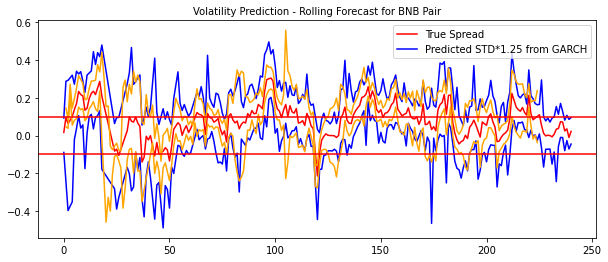

In [44]:
plt.figure(figsize=(10,4))
plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_avg'], color='red')
plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_high'], color='blue')
plt.plot(df[df['spread_high']<=0.5][df['spread_low']>=-0.5]['spread_low'], color='blue')
multiplier = 1.25
df['up_bound'] = df['spread_avg']+(df['predicted_volatility']*multiplier)
df['low_bound'] = df['spread_avg']-(df['predicted_volatility']*multiplier)
plt.plot(df['up_bound'], color='orange')
plt.plot(df['low_bound'], color='orange')
# plt.plot(df['vwma'])
# plt.plot(df['ma'])

plt.axhline(y = 0.1, color = 'red', linestyle = '-')
plt.axhline(y = -0.1, color = 'red', linestyle = '-')

plt.title('Volatility Prediction - Rolling Forecast for {} Pair'.format(coin['perp'].split('-')[0]), fontsize=10)
plt.legend(['True Spread', 'Predicted STD*{} from GARCH'.format(multiplier)], fontsize=10)